In [4]:
import tensorflow as tf
import numpy as np
import os
from tqdm.notebook import tqdm
from itertools import chain
import sys
from skimage.io import imread,imshow
from skimage.transform import resize

DATA_PATH = 'data-science-bowl-2018/stage1_train/'
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

image_ids = next(os.walk(DATA_PATH))[1]

In [5]:
X = np.zeros((len(image_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y = np.zeros((len(image_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

In [6]:
for n,id_ in tqdm(enumerate(image_ids),total=len(image_ids)):
    path = DATA_PATH+id_
    img = imread(path+'/images/'+id_+'.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y[n] = mask
x_train=X
 
y_train=Y

In [7]:
import matplotlib.pyplot as plt

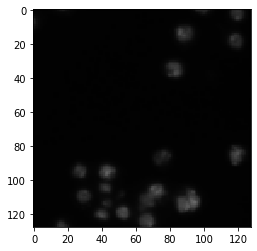

In [8]:
plt.imshow(x_train[0])

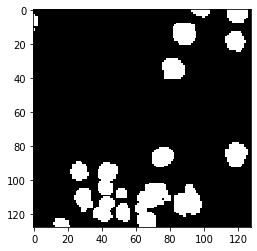

In [9]:
plt.imshow(y_train[0].reshape(128,128),cmap='gray')

In [11]:
x_train = x_train/255

In [19]:
import tensorflow.keras.backend as K
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int3(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [26]:
inp = tf.keras.layers.Input((IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS))

c1 = tf.keras.layers.Conv2D(16,(3,3),activation = 'elu', kernel_initializer='he_normal',padding='same')(inp)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16,(3,3),activation = 'elu', kernel_initializer='he_normal',padding='same')(c1)
p1 = tf.keras.layers.MaxPool2D((2,2))(c1) #64X64

c2 = tf.keras.layers.Conv2D(32,(3,3),activation = 'elu', kernel_initializer='he_normal',padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32,(3,3),activation = 'elu', kernel_initializer='he_normal',padding='same')(c2)
p2 = tf.keras.layers.MaxPool2D((2,2))(c2) #32X32

c3 = tf.keras.layers.Conv2D(64,(3,3),activation = 'elu', kernel_initializer='he_normal',padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.1)(c3)
c3 = tf.keras.layers.Conv2D(64,(3,3),activation = 'elu', kernel_initializer='he_normal',padding='same')(c3)
p3 = tf.keras.layers.MaxPool2D((2,2))(c3) #16X16

c4 = tf.keras.layers.Conv2D(128,(3,3),activation = 'elu', kernel_initializer='he_normal',padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.1)(c4)
c4 = tf.keras.layers.Conv2D(128,(3,3),activation = 'elu', kernel_initializer='he_normal',padding='same')(c4)
p4 = tf.keras.layers.MaxPool2D((2,2))(c4) #8X8

c5 = tf.keras.layers.Conv2D(256,(3,3),activation = 'elu', kernel_initializer='he_normal',padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.1)(c5)
c5 = tf.keras.layers.Conv2D(256,(3,3),activation = 'elu', kernel_initializer='he_normal',padding='same')(c5) #8X8

u6 = tf.keras.layers.Conv2DTranspose(128,(2,2),strides=(2,2),padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6,c4])
c6 = tf.keras.layers.Conv2D(128,(3,3),activation = 'elu', kernel_initializer='he_normal',padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.1)(c6)
c6 = tf.keras.layers.Conv2D(128,(3,3),activation = 'elu', kernel_initializer='he_normal',padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64,(2,2),strides=(2,2),padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7,c3])
c7 = tf.keras.layers.Conv2D(64,(3,3),activation = 'elu', kernel_initializer='he_normal',padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.1)(c7)
c7 = tf.keras.layers.Conv2D(64,(3,3),activation = 'elu', kernel_initializer='he_normal',padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32,(2,2),strides=(2,2),padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8,c2])
c8 = tf.keras.layers.Conv2D(32,(3,3),activation = 'elu', kernel_initializer='he_normal',padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32,(3,3),activation = 'elu', kernel_initializer='he_normal',padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = tf.keras.layers.Dropout(0.1) (c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = tf.keras.models.Model(inputs=[inp], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_80 (Conv2D)              (None, 128, 128, 16) 448         input_8[0][0]                    
__________________________________________________________________________________________________
dropout_38 (Dropout)            (None, 128, 128, 16) 0           conv2d_80[0][0]                  
__________________________________________________________________________________________________
conv2d_81 (Conv2D)              (None, 128, 128, 16) 2320        dropout_38[0][0]                 
____________________________________________________________________________________________

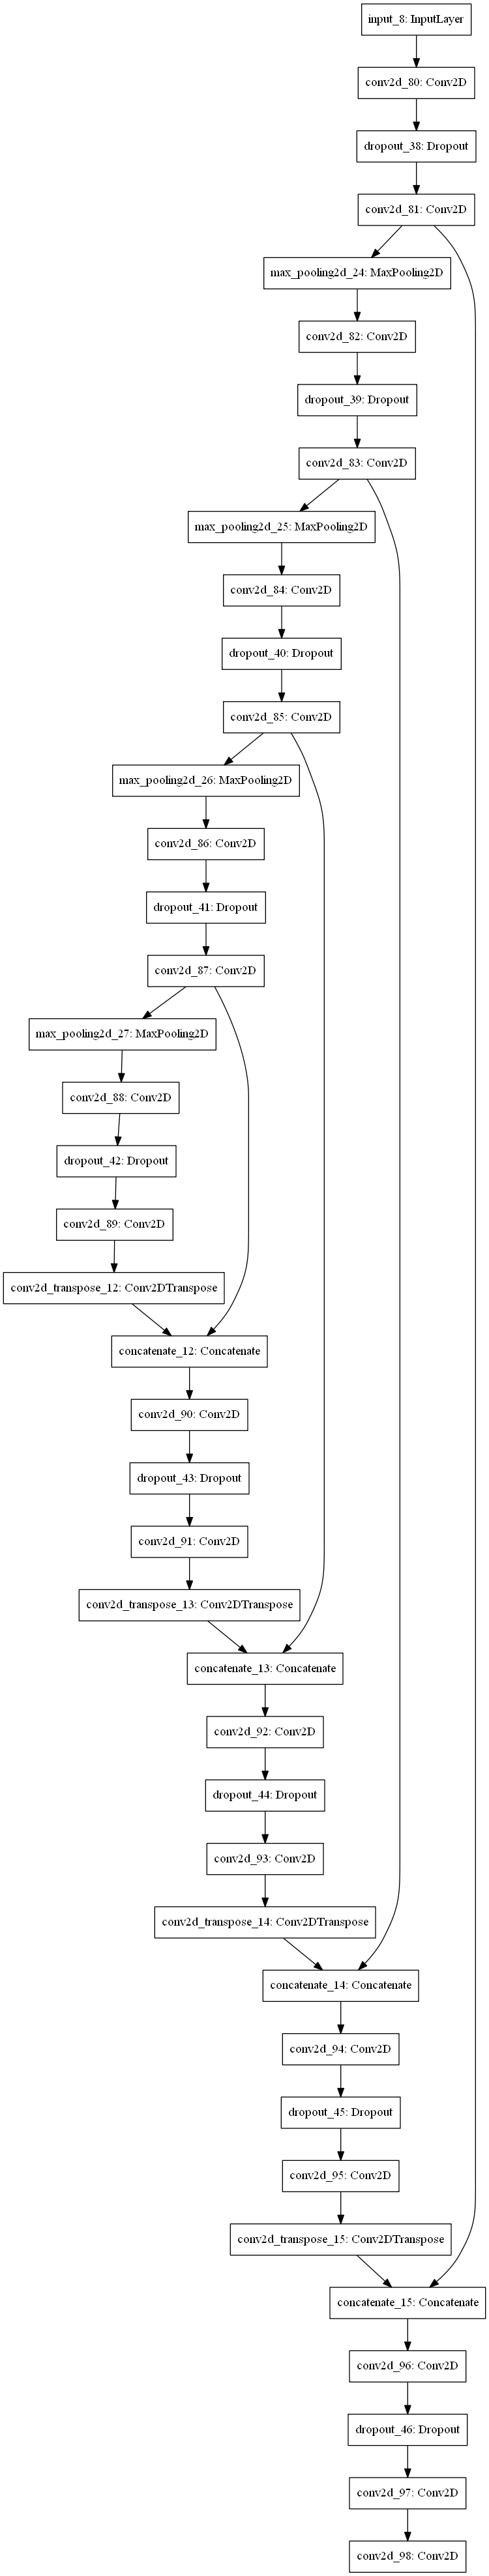

In [27]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

(670, 128, 128, 3)

In [30]:
earlystopper = tf.keras.callbacks.EarlyStopping(patience=5, verbose=1)
checkpointer = tf.keras.callbacks.ModelCheckpoint('model-dsbowl2018-1.h5', verbose=1, save_best_only=True)
results = model.fit(x_train, y_train, validation_split=0.1, batch_size=16, epochs=50, 
                    callbacks=[earlystopper, checkpointer])

Train on 603 samples, validate on 67 samples
Epoch 1/50
592/603 [============================>.] - ETA: 0s - loss: 0.3722 - acc: 0.8416
Epoch 00001: val_loss improved from inf to 0.22121, saving model to model-dsbowl2018-1.h5
603/603 [==============================] - 19s 31ms/sample - loss: 0.3694 - acc: 0.8430 - val_loss: 0.2212 - val_acc: 0.9108
Epoch 2/50
592/603 [============================>.] - ETA: 0s - loss: 0.1985 - acc: 0.9211
Epoch 00002: val_loss improved from 0.22121 to 0.15245, saving model to model-dsbowl2018-1.h5
603/603 [==============================] - 4s 7ms/sample - loss: 0.1982 - acc: 0.9213 - val_loss: 0.1525 - val_acc: 0.9400
Epoch 3/50
592/603 [============================>.] - ETA: 0s - loss: 0.1494 - acc: 0.9423- ETA: 0s - loss: 0.1472 - acc: 0.9
Epoch 00003: val_loss improved from 0.15245 to 0.12042, saving model to model-dsbowl2018-1.h5
603/603 [==============================] - 4s 7ms/sample - loss: 0.1494 - acc: 0.9423 - val_loss: 0.1204 - val_acc: 0.950

Epoch 29/50
592/603 [============================>.] - ETA: 0s - loss: 0.0758 - acc: 0.9700
Epoch 00029: val_loss improved from 0.07318 to 0.07215, saving model to model-dsbowl2018-1.h5
603/603 [==============================] - 4s 7ms/sample - loss: 0.0761 - acc: 0.9699 - val_loss: 0.0721 - val_acc: 0.9710
Epoch 30/50
592/603 [============================>.] - ETA: 0s - loss: 0.0759 - acc: 0.9698
Epoch 00030: val_loss did not improve from 0.07215
603/603 [==============================] - 3s 6ms/sample - loss: 0.0753 - acc: 0.9700 - val_loss: 0.0745 - val_acc: 0.9703
Epoch 31/50
592/603 [============================>.] - ETA: 0s - loss: 0.0745 - acc: 0.9703
Epoch 00031: val_loss did not improve from 0.07215
603/603 [==============================] - 3s 6ms/sample - loss: 0.0747 - acc: 0.9702 - val_loss: 0.0757 - val_acc: 0.9703
Epoch 32/50
592/603 [============================>.] - ETA: 0s - loss: 0.0731 - acc: 0.9708- ETA: 2s - loss: - ETA: 0s - loss: 0.0734 - acc: 0.97
Epoch 00032: 

In [31]:
preds = model.predict(x_train)

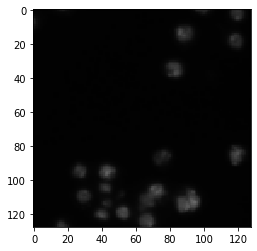

In [32]:
plt.imshow(x_train[0])

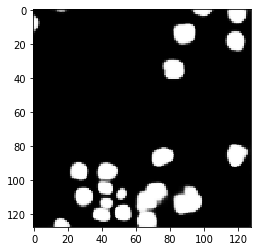

In [35]:
plt.imshow(preds[0].reshape(IMG_HEIGHT,IMG_WIDTH),cmap='gray')

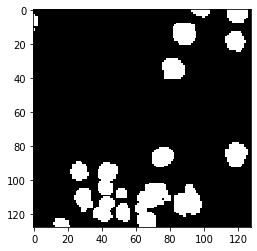

In [36]:
plt.imshow(y_train[0].reshape(IMG_HEIGHT,IMG_WIDTH),cmap='gray')

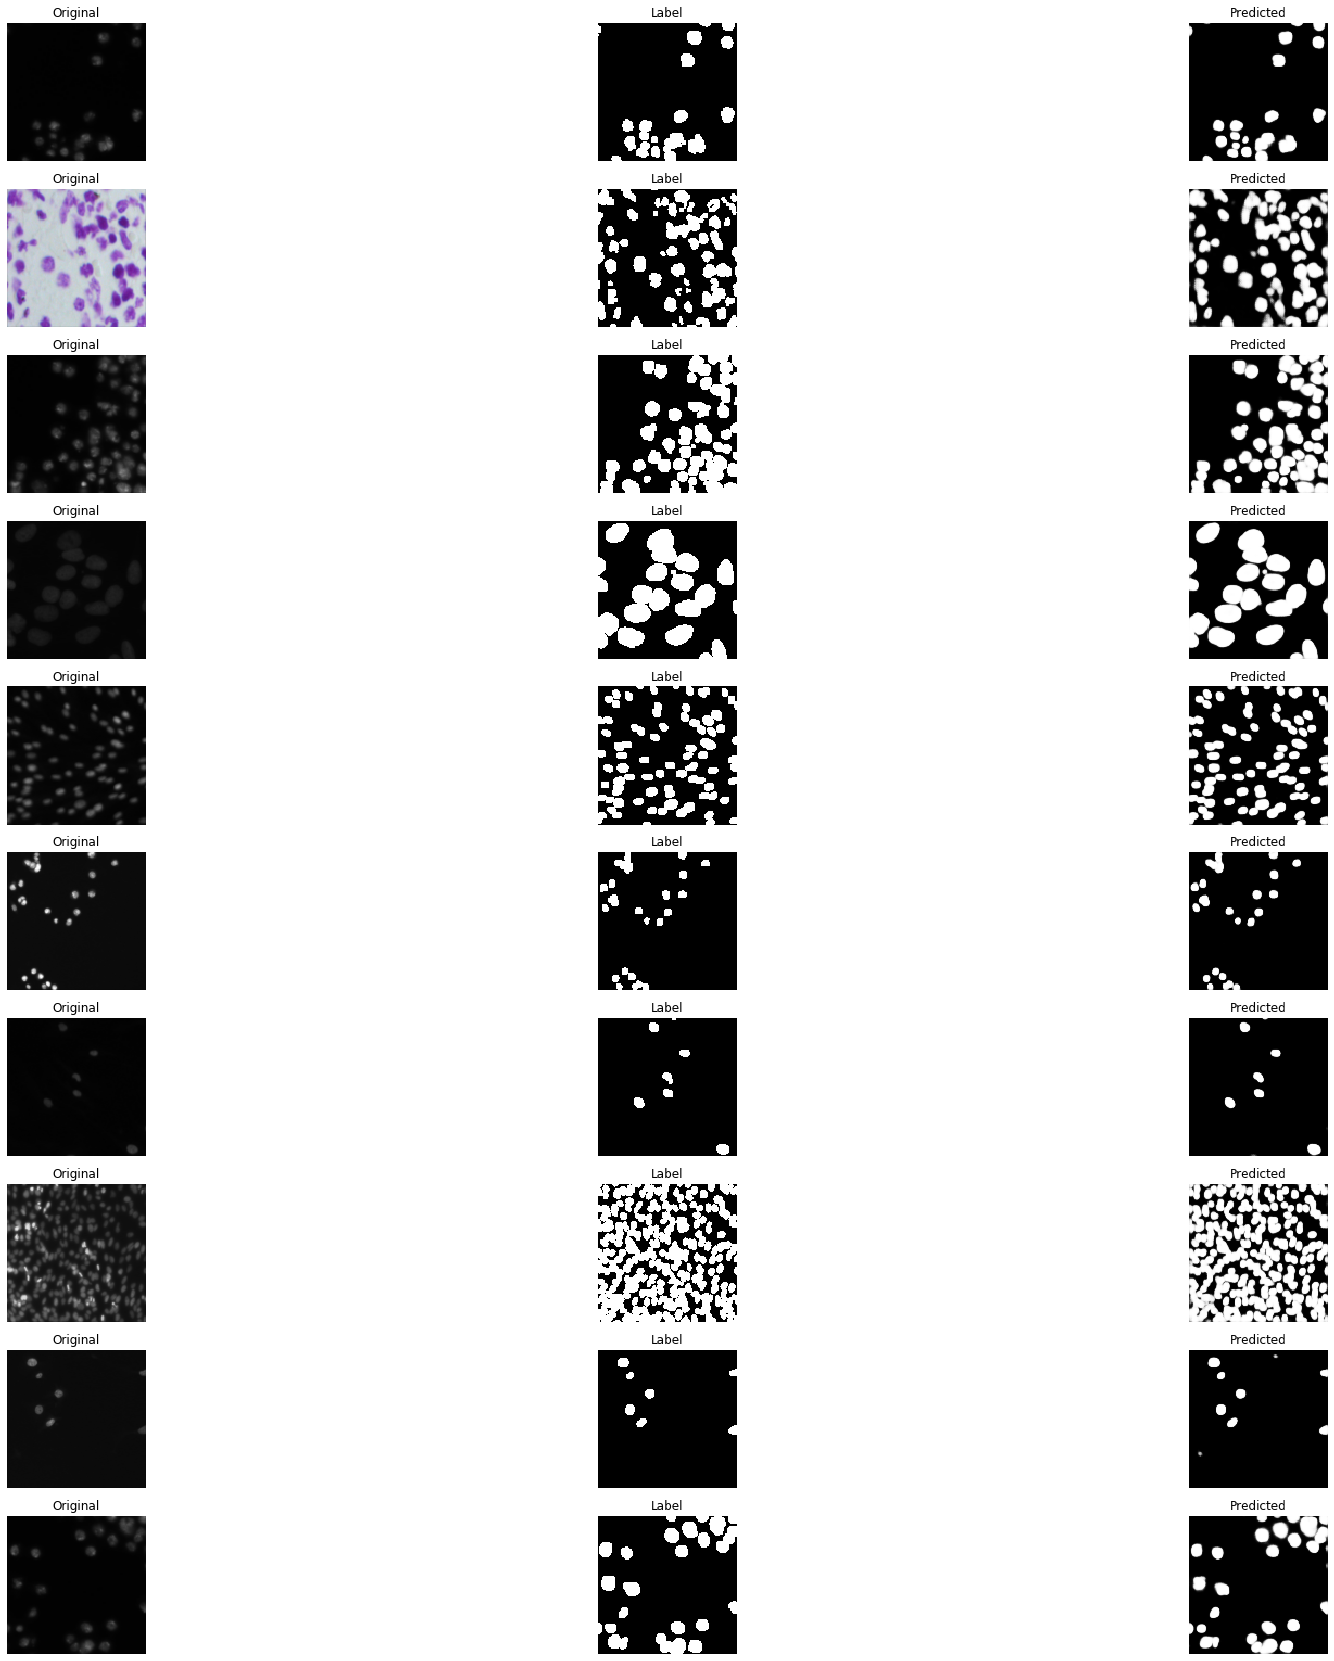

In [71]:
fig,axes = plt.subplots(10,3,figsize=(30,30))
for i in range(30):
    if i%3==0:
        axes.ravel()[i].imshow(x_train[i])
        axes.ravel()[i].set_title("Original")
        axes.ravel()[i].set_axis_off()
    elif i%3==1:
        axes.ravel()[i].imshow(y_train[i-1].reshape(IMG_HEIGHT,IMG_WIDTH), cmap="gray")
        axes.ravel()[i].set_title("Label")
        axes.ravel()[i].set_axis_off()
        
    elif i%3==2:
        axes.ravel()[i].imshow(preds[i-2].reshape(IMG_HEIGHT,IMG_WIDTH), cmap="gray")
        axes.ravel()[i].set_title("Predicted")
        axes.ravel()[i].set_axis_off()
fig.savefig("Results.png")